## Topic modeling for the state of the union addresses from 1989 - 2017

In [62]:
# Import modules
from __future__ import division

import io
import os
import sys
import glob
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import math
import bokeh
import nltk
import string
import logging
import pyLDAvis
import pyLDAvis.gensim
import codecs
import pickle
from collections import defaultdict
from pprint import pprint
from ast import literal_eval
from bokeh.resources import INLINE
from bokeh.plotting import figure, show
from bokeh.sampledata.us_states import data as states
from bokeh.models import ColumnDataSource, Range1d
from bokeh.io import output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import brewer
output_notebook(resources=INLINE)

Loading BokehJS ...

In [63]:
sys.path.append('/Users/danielokeeffe/Documents/src/nlp_preprocessing')
import nlp_preprocessing

In [67]:
# reload(nlp_preprocessing)

<module 'nlp_preprocessing' from '/Users/danielokeeffe/Documents/src/nlp_preprocessing/nlp_preprocessing.py'>

In [3]:
# Set the default encoding for the session
# reload(sys)
# sys.setdefaultencoding('utf-8')

In [4]:
# Set path to mallet:
mallet_path = '/Users/danielokeeffe/Documents/mallet-2.0.8/bin/mallet'

In [5]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [6]:
# Set matplotlib style
plt.style.use('dark_background')

In [7]:
# Set logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load data

In [8]:
file_list = glob.glob('state-of-the-union-corpus-1989-2017/*.txt')

In [9]:
data_dict = {'year':[], 'president': [], 'speech': []}

In [10]:
for file_name in file_list:
    year_ = os.path.splitext(file_name)[0][-4:]
    president = re.findall(r'/([^(]*)\_' , os.path.splitext(file_name)[0])[0]
    with codecs.open(file_name, "r", encoding='utf-8') as f:
        doc_ = f.read()
    # doc_ = re.sub('[^a-zA-Z ]+', '', doc_)
    data_dict['year'].append(year_)
    data_dict['president'].append(president)
    data_dict['speech'].append(doc_)

In [11]:
df = pd.DataFrame.from_dict(data_dict)

In [12]:
df['year'] = df['year'].astype(int)

In [13]:
df = df.sort_values('year', ascending=True)

In [14]:
df.head()

,president,speech,year
17,Bush,"Mr. Speaker, Mr. President, and distinguished Members of the House and Senate, honored guests, and fellow citizens:\nLess than 3 weeks ago, I joined you on the West Front of this very building and, looking over the monuments to our proud past, offered you my hand in filling the next page of American history with a story of extended prosperity and continued peace. And tonight I'm back to offer you my plans as well. The hand remains extended; the sleeves are rolled up; America is waiting; and now we must produce. Together, we can build a better America.\nIt is comforting to return to this historic Chamber. Here, 22 years ago, I first raised my hand to be sworn into public life. So, tonight I feel as if I'm returning home to friends. And I intend, in the months and years to come, to give you what friends deserve: frankness, respect, and my best judgment about ways to improve America's future. In return, I ask for an honest commitment to our common mission of progress. If we seize the ...",1989
16,Bush,"Tonight, I come not to speak about the ""State of the Government"", not to detail every new initiative we plan for the coming year, nor describe every line in the budget. I'm here to speak to you and to the American people about the State of the Union about our world, the changes we've seen, the challenges we face. And what that means for America.\nThere are singular moments in history, dates that divide all that goes before from all that comes after. And many of us in this chamber have lived much of our lives in a world whose fundamental features were defined in 1945. And the events of that year decreed the shape of nations, the pace of progress, freedom or oppression for millions of people around the world.\nNineteen Forty-Five provided the common frame of reference the compass points of the postwar era we've relied upon to understand ourselves. And that was our world until now. The events of the year just ended, the Revolution of '89, have been a chain reaction, changes so strikin...",1990
13,Bush,"Mr. President, Mr. Speaker, members of the United States Congress:\nI come to this house of the people to speak to you and all Americans, certain we stand at a defining hour.\nHalfway around the world, we are engaged in a great struggle in the skies and on the seas and sands. We know why we're there. We are Americans - part of something larger than ourselves.\nFor two centuries we've done the hard work of freedom. And tonight we lead the world in facing down a threat to decency and humanity.\nWhat is at stake is more than one small country, it is a big idea - a new world order, where diverse nations are drawn together in common cause to achieve the universal aspirations of mankind: peace and security, freedom, and the rule of law. Such is a world worthy of our struggle, and worthy of our children's future.\nThe community of nations has resolutely gathered to condemn and repel lawless aggression. Saddam Hussein's unprovoked invasion - his ruthless, systematic rape of a peaceful neig...",1991
9,Bush,"Mr. Speaker and Mr. President, distinguished Members of Congress, honored guests, and fellow citizens:\nThank you very much for that warm reception. You know, with the big buildup this address has had, I wanted to make sure it would be a big hit, but I couldn't convince Barbara to deliver it for me.\nI see the Speaker and the Vice President are laughing. They saw what I did in Japan, and they're just happy they're sitting behind me.\nI mean to speak tonight of big things, of big changes and the promises they hold, and of some big problems and how, together, we can solve them and move our country forward as the undisputed leader of the age.\nWe gather tonight at a dramatic and deeply promising time in our history and in the history of man on Earth. For in the past 12 months, the world has known changes of almost Biblical proportions. And even now, months after the failed coup that doomed a failed system, I'm n

In [15]:
df.shape

(29, 3)

## Preprocessing

In [16]:
# Run preprocessing functions on data.
dictionary, corpus, text_lemma = nlp_preprocessing.lda_preprocess(df=df, text_col='speech', lang_list=['en'], min_count=5, threshold=100, trigrams=False)

  0%|          | 0/29 [00:00<?, ?it/s]

Begin LDA preprocessing
Detecting languages


  0%|          | 0/29 [00:00<?, ?it/s]

Language detection complete. Detected and retained languages: [u'en']
Begin regex preprocessing
Removing newline characters.
Removing single quotes
End regex preprocessing
Begin sentence preprocessing


  0%|          | 0/29 [00:00<?, ?it/s]

End sentence preprocessing
Begin stopword removal


100%|██████████| 29/29 [14:02<00:00, 28.38s/it]
2018-11-21 14:42:05,616 : INFO : collecting all words and their counts
2018-11-21 14:42:05,618 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


end remove stopwords
Building bigrams and trigrams


2018-11-21 14:42:06,004 : INFO : collected 78650 word types from a corpus of 90288 words (unigram + bigrams) and 29 sentences
2018-11-21 14:42:06,006 : INFO : using 78650 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2018-11-21 14:42:06,007 : INFO : source_vocab length 78650
2018-11-21 14:42:07,721 : INFO : Phraser built with 160 phrasegrams
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2018-11-21 14:42:07,725 : INFO : collecting all words and their counts
2018-11-21 14:42:07,747 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-11-21 14:42:08,923 : INFO : collected 79089 word types from a corpus of 87775 words (unigram + bigrams) and 29 sentences
2018-11-21 14:42:08,924 : INFO : using 7

Begin lemmatization


100%|██████████| 29/29 [00:05<00:00,  5.91it/s]
2018-11-21 14:42:18,245 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-11-21 14:42:18,355 : INFO : built Dictionary(6233 unique tokens: [u'narcotic', u'jihad', u'suzann', u'cyprus', u'aggression']...) from 29 documents (total 79521 corpus positions)
  0%|          | 0/29 [00:00<?, ?it/s]

End lemmatization
Begin creating dictionary
End creating dictionary
Being creating corpus


100%|██████████| 29/29 [00:00<00:00, 203.13it/s]

End creating corpus
End LDA preprocessing


In [17]:
len(text_lemma)

29

In [18]:
dictionary[0]

u'ability'

In [19]:
# [[(dictionary[i], freq) for i, freq in cp] for cp in corpus[:1]]

[[(u'ability', 1),
  (u'abraham', 1),
  (u'abuse', 2),
  (u'accompany', 1),
  (u'accountable', 1),
  (u'achieve', 1),
  (u'acid', 1),
  (u'acquisition', 1),
  (u'act', 3),
  (u'action', 3),
  (u'addict', 1),
  (u'addicted', 1),
  (u'addiction', 1),
  (u'addition', 1),
  (u'address', 5),
  (u'adjustment', 1),
  (u'administration', 1),
  (u'administrator', 1),
  (u'adoption', 2),
  (u'aeronautic', 1),
  (u'afford', 1),
  (u'afraid', 1),
  (u'age', 1),
  (u'agency', 3),
  (u'agenda', 1),
  (u'agreement', 4),
  (u'agricultural', 1),
  (u'aid', 3),
  (u'aim', 2),
  (u'air', 2),
  (u'airwave', 1),
  (u'alaska', 1),
  (u'alive', 1),
  (u'alliance', 2),
  (u'allocate', 1),
  (u'allocated', 1),
  (u'allow', 3),
  (u'ally', 1),
  (u'alternative', 1),
  (u'ambition', 1),
  (u'ambitious', 1),
  (u'ameliorate', 1),
  (u'amendment', 2),
  (u'america', 31),
  (u'american', 16),
  (u'americas', 1),
  (u'amount', 1),
  (u'anniversary', 2),
  (u'announce', 1),
  (u'answer', 1),
  (u'anything', 1),
  (u'

# Determine the number of topics for LDA model.

In [17]:
# We won't use Mallet here as it doesn't play well with PYLDAviz
model_list, coherence_values = nlp_preprocessing.compute_coherence_values(dictionary=dictionary, 
                                                                          corpus=corpus, 
                                                                          texts=text_lemma, 
                                                                          limit=24, 
                                                                          start=6, 
                                                                          step=2)

2018-11-21 14:42:18,530 : INFO : using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
2018-11-21 14:42:18,532 : INFO : using symmetric eta at 0.166666666667
2018-11-21 14:42:18,535 : INFO : using serial LDA version on this node
2018-11-21 14:42:18,542 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 29 documents, updating model once every 29 documents, evaluating perplexity every 29 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-21 14:42:18,773 : INFO : -9.600 per-word bound, 776.1 perplexity estimate based on a held-out corpus of 29 documents with 79521 words
2018-11-21 14:42:18,775 : INFO : PROGRESS: pass 0, at document #29/29
2018-11-21 14:42:18,838 : INFO : optimized alpha [0.29652804, 0.29774305, 0.309702, 0.30742484, 0.31403983, 0.3215907]
2018-11-21 14:42:18,849 : INFO : topic #0 (0.297): 0.010*"year" + 0.010*"people" + 0.010*"america" + 0.008*"am

In [18]:
coherence_values

[0.2526291952745056,
 0.2408037720221013,
 0.23655591432583384,
 0.24396891267902263,
 0.24839218859298096,
 0.2534605755235284,
 0.2395177908698349,
 0.24772870923564083,
 0.2509030212595638]

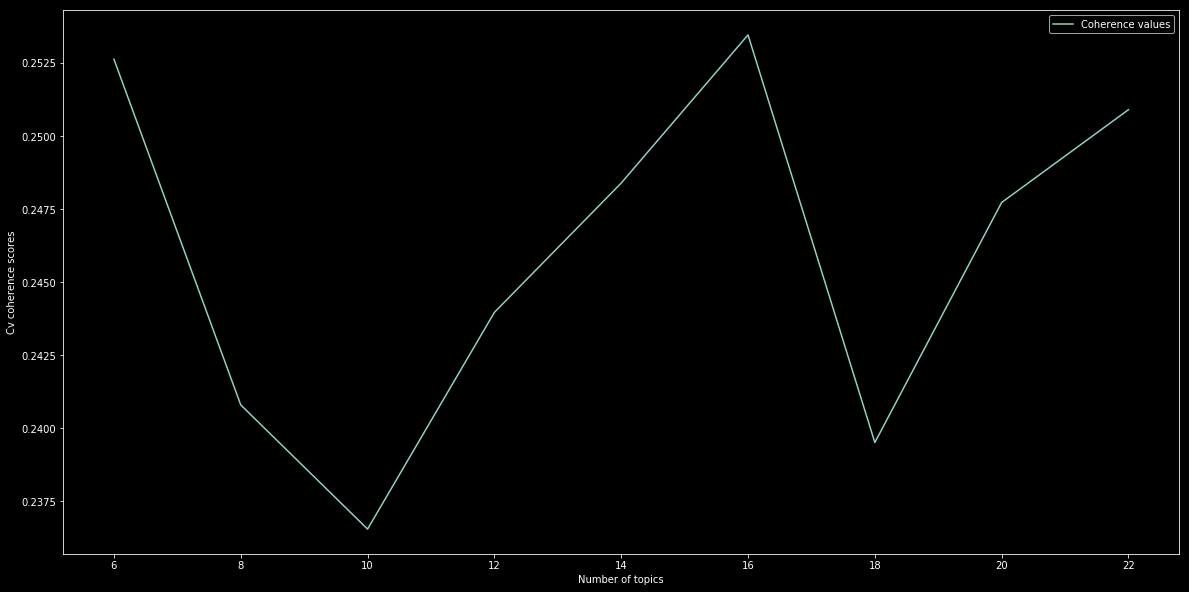

2018-11-21 14:54:07,295 : INFO : topic #0 (0.020): 0.001*"america" + 0.001*"year" + 0.001*"american" + 0.001*"people" + 0.001*"good" + 0.001*"make" + 0.001*"help" + 0.001*"new" + 0.001*"work" + 0.001*"nation"
2018-11-21 14:54:07,297 : INFO : topic #1 (0.020): 0.001*"america" + 0.001*"american" + 0.001*"new" + 0.001*"help" + 0.001*"work" + 0.001*"year" + 0.001*"know" + 0.001*"must" + 0.001*"make" + 0.001*"world"
2018-11-21 14:54:07,298 : INFO : topic #2 (0.021): 0.002*"american" + 0.001*"year" + 0.001*"people" + 0.001*"work" + 0.001*"new" + 0.001*"make" + 0.001*"must" + 0.001*"america" + 0.001*"time" + 0.001*"country"
2018-11-21 14:54:07,300 : INFO : topic #3 (0.020): 0.001*"year" + 0.001*"work" + 0.001*"american" + 0.001*"new" + 0.001*"america" + 0.001*"must" + 0.001*"people" + 0.001*"world" + 0.001*"help" + 0.001*"good"
2018-11-21 14:54:07,302 : INFO : topic #4 (0.029): 0.015*"world" + 0.011*"american" + 0.010*"america" + 0.009*"know" + 0.008*"freedom" + 0.007*"power" + 0.007*"nation"

Number of topics: 6  Cv coherence score: 0.2526
Number of topics: 8  Cv coherence score: 0.2408
Number of topics: 10  Cv coherence score: 0.2366
Number of topics: 12  Cv coherence score: 0.244
Number of topics: 14  Cv coherence score: 0.2484
Number of topics: 16  Cv coherence score: 0.2535
Number of topics: 18  Cv coherence score: 0.2395
Number of topics: 20  Cv coherence score: 0.2477
Number of topics: 22  Cv coherence score: 0.2509
Selecting best model.  Note: this is based on maximizing coherence score.
If the score does not maximize, consider changing topic number range, or select the model that gave the highest coherence score before flattening out.
Examine the plot of number of topics vs coherence score to judge for yourself.
The best model has 16 topics
The topics are:
[(0,
  u'0.001*"america" + 0.001*"year" + 0.001*"american" + 0.001*"people" + 0.001*"good" + 0.001*"make" + 0.001*"help" + 0.001*"new" + 0.001*"work" + 0.001*"nation"'),
 (1,
  u'0.001*"america" + 0.001*"american"

In [19]:
best_model, optimal_topic_num, coherence_value, best_index = nlp_preprocessing.evaluate_model_coherence(model_list=model_list, 
                                                                                                        coherence_values=coherence_values,
                                                                                                        limit=24,
                                                                                                        start=6,
                                                                                                        step=2)

In [68]:
sent_topics_df = nlp_preprocessing.format_topics_sentences_gensim(ldamodel=best_model, corpus=corpus, texts=text_lemma)

In [70]:
df_dominant_topic = nlp_preprocessing.format_dominant_topics_df(sent_topics_df)

In [71]:
df_dominant_topic

,document_number,dominant_topic,topic_percent_contribution,keywords,text
0,0,13.0,0.3250,"year, people, work, must, american, new, america, child, make, good","[mr_president, distinguished, member, house_senate, honor, guests_fellow, citizen, less, week, join, west, front, building, look, monument, proud, offer, hand, fill, next, page, american, history, story, extend, prosperity, continue, peace, tonight, offer, plan, hand, remain, extended, sleeve, roll, america, waiting, must, produce, build, good, america, comfort, return, historic, chamber, year, raise, hand, swear, public, life, tonight, feel, return, home, friend, intend, month, year, give, friend, deserve, frankness, respect, good, judgment, way, improve, america, future, return, ask, honest, commitment, common, mission, progress, seize, opportunity, road, will, praise, enough, people, do, send, bicker, time, govern, many, president, chamber, time, great, crisis, depression, loss, national, ...]"
1,1,5.0,0.9997,"year, american, people, make, work, new, s, america, know, time","[tonight, speak, state, government, detail, new, initiative, plan, come, year, describe, line, budget, speak, american, people, state_union, world, change, have, see, challenge, mean, america, singular, moment, history, date, divide, go, come, many, chamber, live, much, life, world, whose, fundamental, feature, define, event, year, decreed, shape, nation, pace, progress, freedom, oppression, million, people, world, provided, common, frame, reference, compass, point, postwar, have, rely, understand, world, event, year, end, revolution, chain, reaction, change, strike, mark, begin, new, world, affair, think, think, short, month, world, know, begin, year, year, people, panama, live, fear, thumb, dictator, today, democracy, restore, panama, free, operation, because, achieve, ...]"
2,2,4.0,0.7684,"world, american, america, know, freedom, power, nation, people, future, struggle","[mr_president, member, united_state, congress, house, people, speak, american, certain, stand, define, hour, world, engage, great, struggle, sky, sand, know, american, part, something, large, century, have, do, hard, work, freedom, tonight, lead, world, face, threat, decency, humanity, stake, small, country, big, idea, new, world, order, diverse, nation, draw, common, because, achieve, universal, aspiration, mankind, peace, security, freedom, rule_law, world, worthy, struggle, worthy, children, future, community, nation, gather, condemn, repel, lawless, aggression, saddam, hussein, unprovoked, invasion, ruthless, systematic, rape, peaceful, neighbor, violate, everything, community, nation, hold, dear, world, say, aggression, would, stand, stand, resist, trap, appeasement, cynicism, isolation, give, temptation, tyrant, world, ...]"
3,3,5.0,0.9997,"year, american, people, make, work, new, s, america, know, time","[mr_president, distinguished, members_congress, honor, guests_fellow, citizen, thank, much, warm, reception, know, big, buildup, address, want, make_sure, would, big, hit, could, convince, barbara, deliver, see, speaker_vice, president, laugh, see, japan, be, happy, be, sit, mean, speak, tonight, big, thing, big, change, promise, hold, big, problem, solve, move, country, undisputed, leader, age, gather, tonight, dramatic, promising, time, history, history, earth, past, month, world, know, change, biblical, proportion, month, fail, coup, doom, failed, system, sure, have, absorb, full, impact, full, import, happen, communism, die, year, president, fascinating, possible, vantage, point, time, busy, manage, progress, help, lead, change, do, show, joy, heart, big, thing, ...]"
4,4,13.0,0.9997,"year, people, work, must, american, new, america, child, make, good","[mr_president, member, house_senate, distinguish, american, visitor, chamber, nice, fresh, excuse, give, long, speech, president, speak, congress, nation, podium, comment, full, range, challenge, opportunity, united_state, ordinary, time, many, task, require, attenti

In [72]:
most_representative_per_doc = nlp_preprocessing.get_most_representative_document_per_topic(sent_topics_df)

In [73]:
# Not that not all topics will be represented here, just the dominant ones.  
most_representative_per_doc

,topic_number,topic_percent_contribution,keywords,text
0,4.0,0.7684,"world, american, america, know, freedom, power, nation, people, future, struggle","[mr_president, member, united_state, congress, house, people, speak, american, certain, stand, define, hour, world, engage, great, struggle, sky, sand, know, american, part, something, large, century, have, do, hard, work, freedom, tonight, lead, world, face, threat, decency, humanity, stake, small, country, big, idea, new, world, order, diverse, nation, draw, common, because, achieve, universal, aspiration, mankind, peace, security, freedom, rule_law, world, worthy, struggle, worthy, children, future, community, nation, gather, condemn, repel, lawless, aggression, saddam, hussein, unprovoked, invasion, ruthless, systematic, rape, peaceful, neighbor, violate, everything, community, nation, hold, dear, world, say, aggression, would, stand, stand, resist, trap, appeasement, cynicism, isolation, give, temptation, tyrant, world, ...]"
1,5.0,0.9997,"year, american, people, make, work, new, s, america, know, time","[tonight, speak, state, government, detail, new, initiative, plan, come, year, describe, line, budget, speak, american, people, state_union, world, change, have, see, challenge, mean, america, singular, moment, history, date, divide, go, come, many, chamber, live, much, life, world, whose, fundamental, feature, define, event, year, decreed, shape, nation, pace, progress, freedom, oppression, million, people, world, provided, common, frame, reference, compass, point, postwar, have, rely, understand, world, event, year, end, revolution, chain, reaction, change, strike, mark, begin, new, world, affair, think, think, short, month, world, know, begin, year, year, people, panama, live, fear, thumb, dictator, today, democracy, restore, panama, free, operation, because, achieve, ...]"
2,6.0,0.9998,"year, must, america, american, work, child, new, help, nation, ask","[mr_speaker_mr_vice, president, members_congress, honor, guests_fellow, american, tonight, honor, report, state_union, let, begin, salute, new, speaker, house, thank, tonight, extend, invitation, special, guest, sit, gallery, mrs, hastert, lyn, gibson, wei, ling, chestnut, widow, brave, capitol, hill, police_officer, give, life, defend, freedom, house, swearing, ask, work, spirit, civility, bipartisanship, let, tonight, stand, report, america, create, long, peacetime, economic, expansion, history, new, job, wage, rise, twice, rate, inflation, high, homeownership, history, small, welfare_roll, year, low, peacetime, unemployment, first, time, decade, budget, balanced, deficit, surplus, last, year, course, budget, surplus, next, year, thank, pioneering, leadership, low, violent_crime, rate, quarter, century, clean, environment, quarter, century, ...]"
3,12.0,0.9998,"america, american, year, people, new, work, job, make, country, world","[mr_speaker, vice_president, cheney_member, congress, distinguished_guest, fellow_citizen, america, evening, nation, call, great, rise, meet, gather, tonight, hundreds_thousand, american, servicemen_woman, deploy, world, terror, bring, hope, oppress, deliver, justice, violent, make, america, secure, day, law_enforcement, personnel, intelligence, officer, track, terrorist, threat, analyst, examine, airline, passenger, list, woman, new, homeland_security, department, patrolling, coast, border, vigilance, protect, america, american, prove, work, people, world, american, economy, grow, strong, tax_relief, pass, work, tonight, members_congress, take, pride, great, work, compassion, reform, skeptic, think, impossible, raise, standard, public, school, give, senior, citizen, prescription_drug, coverage, medicare, faced, serious, challenge, choice, go, confidence, resolve, turn, dangerous, illusion, terrorist, plot, outlaw, regime, ...]"
4,13.0,0.9998,"year, people, work, must, american, new, america, child, make, good","[thank, much, mr_speaker_mr_vice, president, member, congress, distinguished_g

In [76]:
df_topic_distribution = nlp_preprocessing.topic_distribution_across_docs(sent_topics_df)

In [77]:
df_topic_distribution

,dominant_topic,number_of_documents,percentage_of_documents,topic_keywords
0,12.0,12,0.413793,"america, american, year, people, new, work, job, make, country, world"
1,5.0,7,0.241379,"year, american, people, make, work, new, s, america, know, time"
2,13.0,7,0.241379,"year, people, work, must, american, new, america, child, make, good"
3,6.0,2,0.068966,"year, must, america, american, work, child, new, help, nation, ask"
4,4.0,1,0.034483,"world, american, america, know, freedom, power, nation, people, future, struggle"


## Get time series aspect working

In [78]:
# Add a document number.  They are already in order.
df['document_number'] = range(0, df.shape[0])

In [79]:
df.reset_index(inplace=True, drop=True)

In [80]:
# So the dominant topics by year are:
df_dominant_topics_year = df.merge(df_dominant_topic, on='document_number')

In [81]:
df_dominant_topics_year.head()

,president,speech,year,language,document_number,dominant_topic,topic_percent_contribution,keywords,text
0,Bush,"Mr. Speaker, Mr. President, and distinguished Members of the House and Senate, honored guests, and fellow citizens:\nLess than 3 weeks ago, I joined you on the West Front of this very building and, looking over the monuments to our proud past, offered you my hand in filling the next page of American history with a story of extended prosperity and continued peace. And tonight I'm back to offer you my plans as well. The hand remains extended; the sleeves are rolled up; America is waiting; and now we must produce. Together, we can build a better America.\nIt is comforting to return to this historic Chamber. Here, 22 years ago, I first raised my hand to be sworn into public life. So, tonight I feel as if I'm returning home to friends. And I intend, in the months and years to come, to give you what friends deserve: frankness, respect, and my best judgment about ways to improve America's future. In return, I ask for an honest commitment to our common mission of progress. If we seize the ...",1989,en,0,13.0,0.3250,"year, people, work, must, american, new, america, child, make, good","[mr_president, distinguished, member, house_senate, honor, guests_fellow, citizen, less, week, join, west, front, building, look, monument, proud, offer, hand, fill, next, page, american, history, story, extend, prosperity, continue, peace, tonight, offer, plan, hand, remain, extended, sleeve, roll, america, waiting, must, produce, build, good, america, comfort, return, historic, chamber, year, raise, hand, swear, public, life, tonight, feel, return, home, friend, intend, month, year, give, friend, deserve, frankness, respect, good, judgment, way, improve, america, future, return, ask, honest, commitment, common, mission, progress, seize, opportunity, road, will, praise, enough, people, do, send, bicker, time, govern, many, president, chamber, time, great, crisis, depression, loss, national, ...]"
1,Bush,"Tonight, I come not to speak about the ""State of the Government"", not to detail every new initiative we plan for the coming year, nor describe every line in the budget. I'm here to speak to you and to the American people about the State of the Union about our world, the changes we've seen, the challenges we face. And what that means for America.\nThere are singular moments in history, dates that divide all that goes before from all that comes after. And many of us in this chamber have lived much of our lives in a world whose fundamental features were defined in 1945. And the events of that year decreed the shape of nations, the pace of progress, freedom or oppression for millions of people around the world.\nNineteen Forty-Five provided the common frame of reference the compass points of the postwar era we've relied upon to understand ourselves. And that was our world until now. The events of the year just ended, the Revolution of '89, have been a chain reaction, changes so strikin...",1990,en,1,5.0,0.9997,"year, american, people, make, work, new, s, america, know, time","[tonight, speak, state, government, detail, new, initiative, plan, come, year, describe, line, budget, speak, american, people, state_union, world, change, have, see, challenge, mean, america, singular, moment, history, date, divide, go, come, many, chamber, live, much, life, world, whose, fundamental, feature, define, event, year, decreed, shape, nation, pace, progress, freedom, oppression, million, people, world, provided, common, frame, reference, compass, point, postwar, have, rely, understand, world, event, year, end, revolution, chain, reaction, change, strike, mark, begin, new, world, affair, think, think, short, month, world, know, begin, year, year, people, panama, live, fear, thumb, dictator, today, democracy, restore, panama, free, operation, because, achieve, ...]"
2,Bush,"Mr. President, Mr. Speaker, members of the United States Congress:\nI come to this house o

In [82]:
# What were the presidents talking about?
df_dominant_topics_year[['president', 'dominant_topic', 'keywords', 'year']]

,president,dominant_topic,keywords,year
0,Bush,13.0,"year, people, work, must, american, new, america, child, make, good",1989
1,Bush,5.0,"year, american, people, make, work, new, s, america, know, time",1990
2,Bush,4.0,"world, american, america, know, freedom, power, nation, people, future, struggle",1991
3,Bush,5.0,"year, american, people, make, work, new, s, america, know, time",1992
4,Clinton,13.0,"year, people, work, must, american, new, america, child, make, good",1993
5,Clinton,5.0,"year, american, people, make, work, new, s, america, know, time",1994
6,Clinton,13.0,"year, people, work, must, american, new, america, child, make, good",1995
7,Clinton,13.0,"year, people, work, must, american, new, america, child, make, good",1996
8,Clinton,13.0,"year, people, work, must, american, new, america, child, make, good",1997
9,Clinton,13.0,"year, people, work, must, american, new, america, child, make, good",1998


# Save the dictionary, corpus, the lemmatized text and the best model.

In [90]:
dictionary.save('dictionary_state_of_the_union_2018-10-27.dict')

2018-10-27 15:20:46,892 : INFO : saving Dictionary object under dictionary_state_of_the_union_2018-10-27.dict, separately None
2018-10-27 15:20:46,912 : INFO : saved dictionary_state_of_the_union_2018-10-27.dict


In [91]:
gensim.corpora.MmCorpus.serialize('corpus_state_of_the_union_2018-10-27.mm', corpus)

2018-10-27 15:20:47,443 : INFO : storing corpus in Matrix Market format to corpus_state_of_the_union_2018-10-27.mm
2018-10-27 15:20:47,445 : INFO : saving sparse matrix to corpus_state_of_the_union_2018-10-27.mm
2018-10-27 15:20:47,447 : INFO : PROGRESS: saving document #0
2018-10-27 15:20:47,609 : INFO : saved 29x6233 matrix, density=17.320% (31308/180757)
2018-10-27 15:20:47,610 : INFO : saving MmCorpus index to corpus_state_of_the_union_2018-10-27.mm.index


In [92]:
best_model.save('state_of_the_union_mallet_lda_11_topics.model')

2018-10-27 15:20:48,123 : INFO : saving LdaMallet object under state_of_the_union_mallet_lda_11_topics.model, separately None
2018-10-27 15:20:48,140 : INFO : saved state_of_the_union_mallet_lda_11_topics.model


In [93]:
from gensim.test.utils import datapath

In [94]:
# What does this do?
# Save model to disk.
temp_file = datapath("model")
best_model.save(temp_file)

2018-10-27 15:20:51,044 : INFO : saving LdaMallet object under /Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/gensim/test/test_data/model, separately None
2018-10-27 15:20:51,061 : INFO : saved /Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/gensim/test/test_data/model


In [96]:
with open('text_lemmas_state_of_the_union_2018-10-27.pkl', 'wb') as f:
    pickle.dump(text_lemma, f)

# Plot the topics

In [83]:
# gensim_best_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)

In [84]:
viz_lda = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [87]:
plt.style.use('ggplot')

In [90]:
pyLDAvis.display(viz_lda)

In [89]:
pyLDAvis.show(viz_lda)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [21/Nov/2018 16:10:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2018 16:10:30] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2018 16:10:30] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2018 16:10:30] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2018 16:10:30] code 404, message Not Found
127.0.0.1 - - [21/Nov/2018 16:10:30] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


In [91]:
# Ok now let's get all of the topic distributions.  

In [95]:
best_model.show_topics(num_topics=16)

[(0,
  u'0.001*"america" + 0.001*"year" + 0.001*"american" + 0.001*"people" + 0.001*"good" + 0.001*"make" + 0.001*"help" + 0.001*"new" + 0.001*"work" + 0.001*"nation"'),
 (1,
  u'0.001*"america" + 0.001*"american" + 0.001*"new" + 0.001*"help" + 0.001*"work" + 0.001*"year" + 0.001*"know" + 0.001*"must" + 0.001*"make" + 0.001*"world"'),
 (2,
  u'0.002*"american" + 0.001*"year" + 0.001*"people" + 0.001*"work" + 0.001*"new" + 0.001*"make" + 0.001*"must" + 0.001*"america" + 0.001*"time" + 0.001*"country"'),
 (3,
  u'0.001*"year" + 0.001*"work" + 0.001*"american" + 0.001*"new" + 0.001*"america" + 0.001*"must" + 0.001*"people" + 0.001*"world" + 0.001*"help" + 0.001*"good"'),
 (4,
  u'0.015*"world" + 0.011*"american" + 0.010*"america" + 0.009*"know" + 0.008*"freedom" + 0.007*"power" + 0.007*"nation" + 0.007*"people" + 0.006*"future" + 0.005*"struggle"'),
 (5,
  u'0.012*"year" + 0.012*"american" + 0.010*"people" + 0.009*"make" + 0.009*"work" + 0.008*"new" + 0.008*"s" + 0.008*"america" + 0.007*"

In [101]:
documents_topic_dists = {}
for i, row in enumerate(best_model.get_document_topics(corpus)):
    documents_topic_dists[i] = row

In [103]:
documents_topic_dists = {}
for i, row in enumerate(best_model.get_document_topics(corpus)):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    document_num = i
    topic_list = []
    val_list = []
    for tup_ in row:
        topic_list.append(tup_[0])
        val_list.append(tup_[1])
    documents_topic_dists[document_num] = {'topic number': topic_list, 'topic contribution': val_list}

In [104]:
documents_topic_dists

{0: {'topic contribution': [0.32494694,
   0.21201757,
   0.1794053,
   0.15676679,
   0.12580769],
  'topic number': [13, 8, 5, 12, 6]},
 1: {'topic contribution': [0.99967563], 'topic number': [5]},
 2: {'topic contribution': [0.7683719, 0.23084942], 'topic number': [4, 6]},
 3: {'topic contribution': [0.9994508], 'topic number': [5]},
 4: {'topic contribution': [0.999736], 'topic number': [13]},
 5: {'topic contribution': [0.51086223, 0.48899776], 'topic number': [5, 13]},
 6: {'topic contribution': [0.75969076, 0.24018936], 'topic number': [13, 5]},
 7: {'topic contribution': [0.99979424], 'topic number': [13]},
 8: {'topic contribution': [0.78730816, 0.18040818, 0.032123845],
  'topic number': [13, 6, 9]},
 9: {'topic contribution': [0.5346236, 0.37507576, 0.07647657, 0.013742781],
  'topic number': [13, 6, 5, 12]},
 10: {'topic contribution': [0.9998249], 'topic number': [6]},
 11: {'topic contribution': [0.6569047, 0.26210654, 0.07690621],
  'topic number': [5, 6, 13]},
 12: {'t

In [ ]:
# TODO: This is for mallet models.  Turn this into a function.

In [72]:
documents_topic_dists = {}
for i, row in enumerate(best_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    document_num = i
    topic_list = []
    val_list = []
    for tup_ in row:
        topic_list.append(tup_[0])
        val_list.append(tup_[1])
    documents_topic_dists[document_num] = {'topic number': topic_list, 'topic contribution': val_list}

2018-10-16 16:09:09,591 : INFO : serializing temporary corpus to /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.txt
2018-10-16 16:09:09,836 : INFO : converting temporary corpus to MALLET format with /Users/danielokeeffe/Documents/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.txt --output /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet.infer --use-pipe-from /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet
2018-10-16 16:09:10,424 : INFO : inferring topics with MALLET LDA '/Users/danielokeeffe/Documents/mallet-2.0.8/bin/mallet infer-topics --input /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet.infer --inferencer /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_inferencer.mallet --output-doc-topics /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_doctopics.txt.infer

In [94]:
documents_topic_dists = {}
for i, row in enumerate(best_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    document_num = i
    topic_dict = {}
    for tup_ in row:
        topic_num = 'topic_{0}_contribution'.format(tup_[0])
        topic_dict[topic_num] = tup_[1]
    documents_topic_dists[document_num] = topic_dict

2018-10-16 16:29:02,220 : INFO : serializing temporary corpus to /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.txt
2018-10-16 16:29:02,477 : INFO : converting temporary corpus to MALLET format with /Users/danielokeeffe/Documents/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.txt --output /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet.infer --use-pipe-from /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet
2018-10-16 16:29:03,191 : INFO : inferring topics with MALLET LDA '/Users/danielokeeffe/Documents/mallet-2.0.8/bin/mallet infer-topics --input /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_corpus.mallet.infer --inferencer /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_inferencer.mallet --output-doc-topics /var/folders/4b/l5r7bzzs3sj751l08nj4x25h0000gp/T/3b3681_doctopics.txt.infer

In [99]:
document_topic_dists_df = pd.DataFrame.from_dict(documents_topic_dists, orient='index')

In [101]:
document_topic_dists_df.reset_index(inplace=True)

In [103]:
document_topic_dists_df.rename(index=str, columns={'index': 'document_number'}, inplace=True)

In [108]:
arrange_cols = ['topic_{0}_contribution'.format(x) for x in range(0, document_topic_dists_df.shape[1] - 1)]

In [109]:
arrange_cols = ['document_number'] + arrange_cols

In [110]:
document_topic_dists_df = document_topic_dists_df[arrange_cols]

In [111]:
document_topic_dists_df

,document_number,topic_0_contribution,topic_1_contribution,topic_2_contribution,topic_3_contribution,topic_4_contribution,topic_5_contribution,topic_6_contribution,topic_7_contribution,topic_8_contribution,topic_9_contribution,topic_10_contribution
0,0,0.159171,0.101856,0.107588,0.048911,0.073653,0.085456,0.173925,0.125066,0.018608,0.006918,0.098849
1,1,0.322094,0.086514,0.055473,0.051754,0.045834,0.094104,0.083023,0.123855,0.033767,0.016083,0.087501
2,2,0.268845,0.148451,0.120316,0.105892,0.062404,0.048908,0.074329,0.073187,0.008634,0.040768,0.048265
3,3,0.144416,0.090096,0.034658,0.150124,0.060729,0.026772,0.184493,0.092921,0.017532,0.028949,0.169310
4,4,0.028831,0.072171,0.016104,0.196721,0.037953,0.044983,0.241441,0.099849,0.018997,0.007116,0.235835
5,5,0.097927,0.020574,0.028640,0.116104,0.172644,0.068811,0.117914,0.095724,0.022974,0.009675,0.249013
6,6,0.047496,0.047915,0.011436,0.093008,0.221905,0.033616,0.075989,0.116130,0.012273,0.030164,0.310069
7,7,0.061123,0.053755,0.010229,0.051435,0.370215,0.046614,0.074722,0.154906,0.022418,0.024783,0.129800
8,8,0.102264,0.050475,0.009699,0.044826,0.270487,0.191309,0.081958,0.164166,0.023005,0.020794,0.041018
9,9,0.077429,0.043867,0.038829,0.063167,0.206252,0.207802,0.059679,0.156567,0.045611,0.028327,0.072469


In [88]:
test_df = pd.concat({k: pd.DataFrame(v) for k, v in documents_topic_dists.items()})

In [89]:
test_df.reset_index(inplace=True)

In [90]:
test_df.drop('level_1', axis=1, inplace=True)

In [92]:
test_df.rename(index=str, columns={'level_0': 'document_number'}, inplace=True)

In [93]:
test_df

,document_number,topic contribution,topic number
0,0,0.173925,6
1,0,0.159171,0
2,0,0.125066,7
3,0,0.107588,2
4,0,0.101856,1
5,0,0.098849,10
6,0,0.085456,5
7,0,0.073653,4
8,0,0.048911,3
9,0,0.018608,8


In [65]:
best_model.print_topic(1)

u'0.041*"american" + 0.035*"america" + 0.030*"make" + 0.028*"nation" + 0.026*"world" + 0.022*"good" + 0.021*"future" + 0.012*"worker" + 0.011*"stop" + 0.011*"promise"'